## Final Assignment Overview: Working with Patient Records and Encounter Notes

In this final assignment, we’ll focus on patient records related to COVID-19 encounters. Our task is to analyze, process, and transform the data while applying the concepts we’ve covered throughout this course. Here's a detailed breakdown of the assignment:

What Are Encounter Notes?
An encounter note is a record that captures details about a patient’s visit with a doctor. It includes both structured and semi-structured information that is crucial for understanding the context of the visit. Here’s what an encounter note typically looks like:

```
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity 

Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms including:
- Cough
- Sore throat
- Severe fatigue
- Muscle pain
- Joint pain
- Fever
Never smoker. Symptoms began recently.

OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg

Laboratory/Testing:
Comprehensive Respiratory Panel:
- Influenza A RNA: Negative
- Influenza B RNA: Negative
- RSV RNA: Negative
- Parainfluenza virus 1,2,3 RNA: Negative
- Rhinovirus RNA: Negative
- Human metapneumovirus RNA: Negative
- Adenovirus DNA: Negative
- SARS-CoV-2 RNA: Positive

ASSESSMENT:
1. Suspected COVID-19 with severe symptoms
2. Severe hypoxemia requiring immediate intervention
3. Tachycardia (HR 131)
4. High-grade fever
5. Risk factors:
   - Obesity (BMI 33.8)
   - Adolescent age

PLAN:
1. Face mask provided for immediate oxygen support
2. Infectious disease care plan initiated
3. Close monitoring required due to:
   - Severe hypoxemia
   - Tachycardia
   - Age and obesity risk factors
4. Parent/patient education on:
   - Home isolation protocols
   - Warning signs requiring emergency care
   - Return precautions
5. Follow-up plan:
   - Daily monitoring during acute phase
   - Virtual check-ins as needed

Encounter Duration: 45 minutes
Encounter Type: Ambulatory
Provider: ID# e2c226c2-3e1e-3d0b-b997-ce9544c10528
Facility: 5103c940-0c08-392f-95cd-446e0cea042a
```


The enocuter contains

* General encounter information: 

  * When the encounter took place: Date and time of the visit.
  * Demographics: Patient’s age, gender, and unique medical record identifier.
  * Encounter details: The reason for the visit, diagnosis, and any associated costs.


* Semi-Structured Notes:

These notes mirror how doctors organize their thoughts and observations during an encounter. They generally follow a SOAP format:

* Subjective: The patient’s subjective description of their symptoms, feelings, and medical concerns.
* Objective: The doctor’s objective findings, including test results, measurements, or physical examination outcomes.
* Assessment: The doctor’s evaluation or diagnosis based on subjective and objective information.
* Plan: The proposed treatment plan, including medications, follow-ups, or other interventions.

While some encounter notes might include additional details, the majority conform to this semi-structured format, making them ideal for analysis and transformation.

* Goals for the Assignment

1. Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assing the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

The JSON format should capture the hierachies described in the structure below. 




2. Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations


In [2]:
from typing import List, Optional
from pydantic import BaseModel


class EncounterType(BaseModel):
    code: str
    description: str


class Encounter(BaseModel):
    date: str
    time: str
    provider_id: str
    facility_id: str


class Address(BaseModel):
    city: str
    state: str


class Demographics(BaseModel):
    name: str
    date_of_birth: str
    age: int
    gender: str
    address: Address
    insurance: str


class Condition(BaseModel):
    code: str
    description: str


class Medication(BaseModel):
    code: str
    description: str


class Immunization(BaseModel):
    code: str
    description: str
    date: str


class VitalMeasurement(BaseModel):
    code: str
    value: float
    unit: str


class BloodPressure(BaseModel):
    systolic: Optional[VitalMeasurement]
    diastolic: Optional[VitalMeasurement]


class CurrentVitals(BaseModel):
    temperature: Optional[VitalMeasurement] = None
    heart_rate: Optional[VitalMeasurement] = None
    blood_pressure: Optional[BloodPressure] = None
    respiratory_rate: Optional[VitalMeasurement] = None
    oxygen_saturation: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None


class BaselineVitals(BaseModel):
    date: str
    height: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None
    bmi: Optional[VitalMeasurement] = None
    bmi_percentile: Optional[VitalMeasurement] = None


class Vitals(BaseModel):
    current: Optional[CurrentVitals] = None
    baseline: Optional[BaselineVitals] = None


class RespiratoryTest(BaseModel):
    code: str
    result: str


class RespiratoryPanel(BaseModel):
    influenza_a: Optional[RespiratoryTest] = None
    influenza_b: Optional[RespiratoryTest] = None
    rsv: Optional[RespiratoryTest] = None
    parainfluenza_1: Optional[RespiratoryTest] = None
    parainfluenza_2: Optional[RespiratoryTest] = None
    parainfluenza_3: Optional[RespiratoryTest] = None
    rhinovirus: Optional[RespiratoryTest] = None
    metapneumovirus: Optional[RespiratoryTest] = None
    adenovirus: Optional[RespiratoryTest] = None


class Covid19Test(BaseModel):
    code: str
    description: str
    result: str


class Laboratory(BaseModel):
    covid19: Optional[Covid19Test] = None
    respiratory_panel: Optional[RespiratoryPanel] = None


class Procedure(BaseModel):
    code: str
    description: str
    date: str
    reasonCode: str
    reasonDescription: str


class CarePlan(BaseModel):
    code: str
    description: str
    start: str
    stop: str
    reasonCode: str
    reasonDescription: str


class PatientRecord(BaseModel):
    demographics: Demographics
    encounter: Optional[Encounter] = None
    conditions: Optional[List[Condition]] = None
    medications: Optional[List[Medication]] = None
    immunizations: Optional[List[Immunization]] = None
    vitals: Optional[Vitals] = None
    laboratory: Optional[Laboratory] = None
    procedures: Optional[List[Procedure]] = None

In [13]:
import os

from langchain_openai import ChatOpenAI

API_KEY = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4", temperature=0, api_key=API_KEY)  # Temperature=0 for deterministic outputs
structured_llm = llm.with_structured_output(PatientRecord)

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, ArrayType, MapType

# Corrected schema
schema = StructType([
    StructField("demographics", StructType([
        StructField("name", StringType(), True),
        StructField("date_of_birth", StringType(), True),
        StructField("age", IntegerType(), True),
        StructField("gender", StringType(), True),
        StructField("address", StructType([
            StructField("city", StringType(), True),
            StructField("state", StringType(), True)
        ]), True),
        StructField("insurance", StringType(), True)
    ]), True),
    StructField("encounter", StructType([
        StructField("date", StringType(), True),
        StructField("time", StringType(), True),
        StructField("provider_id", StringType(), True),
        StructField("facility_id", StringType(), True)
    ]), True),
    StructField("conditions", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True)
    ])), True),
    StructField("medications", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True)
    ]), True), True),
    StructField("immunizations", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True),
        StructField("date", StringType(), True)
    ])), True),
    StructField("vitals", StructType([
        StructField("current", StructType([
            StructField("temperature", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("heart_rate", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("blood_pressure", StructType([
                StructField("systolic", StructType([
                    StructField("code", StringType(), True),
                    StructField("value", DoubleType(), True),
                    StructField("unit", StringType(), True)
                ]), True),
                StructField("diastolic", StructType([
                    StructField("code", StringType(), True),
                    StructField("value", DoubleType(), True),
                    StructField("unit", StringType(), True)
                ]), True)
            ]), True),
            StructField("respiratory_rate", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("oxygen_saturation", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("weight", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True)
        ]), True),
        StructField("baseline", StructType([
            StructField("date", StringType(), True),
            StructField("height", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("weight", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("bmi", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True),
            StructField("bmi_percentile", StructType([
                StructField("code", StringType(), True),
                StructField("value", DoubleType(), True),
                StructField("unit", StringType(), True)
            ]), True)
        ]), True)
    ]), True),
    StructField("laboratory", StructType([
        StructField("covid19", StructType([
            StructField("code", StringType(), True),
            StructField("description", StringType(), True),
            StructField("result", StringType(), True)
        ]), True),
        StructField("respiratory_panel", StructType([
            StructField("influenza_a", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("influenza_b", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("rsv", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("parainfluenza_1", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("parainfluenza_2", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("parainfluenza_3", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("rhinovirus", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("metapneumovirus", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("adenovirus", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True)
        ]), True)
    ]), True),
    StructField("procedures", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True),
        StructField("date", StringType(), True),
        StructField("reasonCode", StringType(), True),
        StructField("reasonDescription", StringType(), True)
    ])), True),
])

In [15]:
import json
import pandas as pd
from pyspark.sql import SparkSession

def save_to_json(pydantic_obj, json_file_path):
    data_dict = pydantic_obj.dict()
    with open(json_file_path, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)

def save_to_parquet(json_file_path, parquet_file_path, schema):
    spark = SparkSession.builder \
        .appName("JSON to Parquet Conversion") \
        .getOrCreate()
    
    df = spark.read.option("multiLine", True).schema(schema).json(json_file_path)
    df.write.mode("overwrite").parquet(parquet_file_path)




In [16]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json

# Initialize Spark session
spark = SparkSession.builder.appName("EncounterNotesProcessing").getOrCreate()

# Load the provided CSV files as Spark DataFrames
encounters = spark.read.csv("data/encounters_assignment_1.csv", header=True, inferSchema=True)
encounter_types = spark.read.csv("data/encounters_types_assignment_1.csv", header=True, inferSchema=True)
immunizations = spark.read.csv("data/immunizations_assignment_1.csv", header=True, inferSchema=True)
medications = spark.read.csv("data/medications_assignment_1.csv", header=True, inferSchema=True)

# Merge encounters with encounter types to update descriptions using Spark DataFrame join
encounters = encounters.join(encounter_types, on="CODE", how="left")

# Function to build a similarity search index using TF-IDF
from faiss import IndexFlatL2
import numpy as np

def build_faiss_index(data, column):
    # Collect the column as a Pandas Series or list
    data_list = data.select(column).rdd.flatMap(lambda x: x).collect()
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data_list)
    faiss_index = IndexFlatL2(tfidf_matrix.shape[1])
    faiss_index.add(tfidf_matrix.toarray().astype(np.float32))
    return vectorizer, faiss_index


# Build FAISS indexes for medications and immunizations
medication_vectorizer, medication_faiss = build_faiss_index(medications, "DESCRIPTION")
immunization_vectorizer, immunization_faiss = build_faiss_index(immunizations, "DESCRIPTION")

# Function to find the best match using FAISS

def find_best_match_faiss(query, vectorizer, faiss_index, data, threshold=0.3):
    query_vec = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = faiss_index.search(query_vec, 1)
    best_match_idx = indices[0][0]
    best_match_score = 1 - distances[0][0]  # Convert distance to similarity
    if best_match_score >= threshold:
        return data.collect()[best_match_idx]["DESCRIPTION"], best_match_score
    return None, 0

# Example usage for mapping encounter notes to medications and immunizations
def map_to_taxonomy_faiss(data, column, vectorizer, faiss_index, taxonomy_data):
    mapped_data = []
    for entry in data[column].collect():
        best_match, best_match_score = find_best_match_faiss(entry, vectorizer, faiss_index, taxonomy_data)
        mapped_data.append(best_match)
    return mapped_data


In [18]:
input_directory = "data/encounter_notes"
output_json_directory = "output/json"
output_parquet_directory = "output/parquet"

os.makedirs(output_json_directory, exist_ok=True)
os.makedirs(output_parquet_directory, exist_ok=True)

for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        input_file_path = os.path.join(input_directory, filename)

        # Read the encounter note
        with open(input_file_path) as f:
            encounter_note = f.read()

        # Generate structured data using the LLM
        structured_data = structured_llm.invoke(encounter_note)

        # Map medications and immunizations using FAISS
        if "MEDICATION" in structured_data:
            structured_data["MEDICATION_MAPPED"] = map_to_taxonomy_faiss(
                structured_data, "MEDICATION", medication_vectorizer, medication_faiss, medications
            )
        if "IMMUNIZATION" in structured_data:
            structured_data["IMMUNIZATION_MAPPED"] = map_to_taxonomy_faiss(
                structured_data, "IMMUNIZATION", immunization_vectorizer, immunization_faiss, immunizations
            )
            
        # Define output file paths
        base_filename = os.path.splitext(filename)[0]
        json_file_path = os.path.join(output_json_directory, f"{base_filename}.json")
        parquet_file_path = os.path.join(output_parquet_directory, f"{base_filename}.parquet")

        # Save to JSON and Parquet
        save_to_json(structured_data, json_file_path)
        save_to_parquet(json_file_path, parquet_file_path, schema)

/var/folders/2y/zw7pvlfs5qn30r_tbtvh8l040000gn/T/ipykernel_63309/481491814.py:6: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  data_dict = pydantic_obj.dict()
24/12/15 11:46:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [19]:
def load_all_parquet_into_dataframe(parquet_directory):
    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("Parquet to DataFrame") \
        .getOrCreate()

    # List to hold individual DataFrames
    dataframes = []

    # Iterate through all parquet files in the directory
    for filename in os.listdir(parquet_directory):
        if filename.endswith(".parquet"):
            parquet_file_path = os.path.join(parquet_directory, filename)
            
            # Read the Parquet file into a Spark DataFrame
            df = spark.read.parquet(parquet_file_path)
            dataframes.append(df)

    # Combine all DataFrames into a single DataFrame
    if dataframes:
        combined_df = dataframes[0]
        for df in dataframes[1:]:
            combined_df = combined_df.union(df)
        
        # Show the combined DataFrame
        combined_df.show()
        return combined_df
    else:
        print("No parquet files found.")
        return None

# Load all parquet files into a single DataFrame
combined_dataframe = load_all_parquet_into_dataframe(output_parquet_directory)

24/12/15 12:03:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/12/15 12:03:29 WARN DAGScheduler: Broadcasting large task binary with size 1054.8 KiB
24/12/15 12:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1054.8 KiB
24/12/15 12:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1054.8 KiB


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        demographics|           encounter|          conditions|         medications|       immunizations|              vitals|          laboratory|          procedures|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{Jayson Fadel, 6/...|{March 11, 2020, ...|[{I10, Hypertensi...|[{C09DB01, amLODI...|[{90656, Influenz...|{{{8310-5, 41.1, ...|{{94500-6, COVID-...|                NULL|
|{Mr. Milo271 Feil...|{02/25/2020, 15:3...|[{J01.90, Acute s...|                NULL|                NULL|{{{8310-5, 39.9, ...|{{94500-6, SARS-C...|                NULL|
|{Mrs. Leann224 De...|{March 8, 2020, 2...|[{U07.1, COVID-19...|                NULL|                NULL|{{{8310-5, 40.1, ...|{{94500-6, SARS-C...|[{

In [25]:
combined_dataframe.printSchema()

root
 |-- demographics: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- date_of_birth: string (nullable = true)
 |    |-- age: integer (nullable = true)
 |    |-- gender: string (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |-- insurance: string (nullable = true)
 |-- encounter: struct (nullable = true)
 |    |-- date: string (nullable = true)
 |    |-- time: string (nullable = true)
 |    |-- provider_id: string (nullable = true)
 |    |-- facility_id: string (nullable = true)
 |-- conditions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |-- medications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- description: string (nullable = tru

In [139]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EncounterNotesProcessing").getOrCreate()
parsed_notes = spark.read.json("data/parsed_notes.jsonl.gz")


# Task 2 - Data Analysis

COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])

<Figure size 800x600 with 0 Axes>

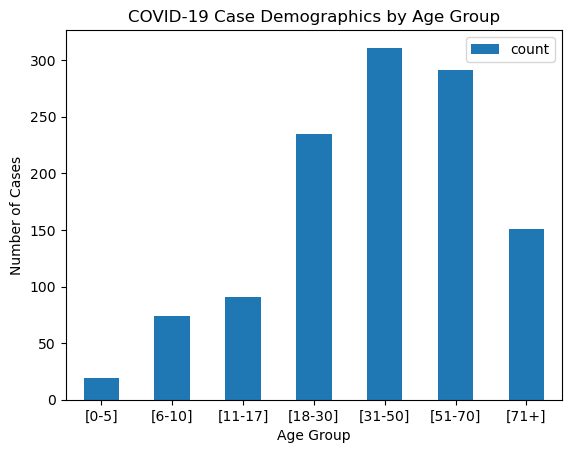

In [140]:
from matplotlib import pyplot as plt
from pyspark.sql.functions import when, col, count
import pandas as pd

# Add age group column
df_with_age_groups = parsed_notes.withColumn(
    "age_group",
    when(col("demographics.age") <= 5, "[0-5]")
    .when((col("demographics.age") <= 10), "[6-10]")
    .when((col("demographics.age") <= 17), "[11-17]")
    .when((col("demographics.age") <= 30), "[18-30]")
    .when((col("demographics.age") <= 50), "[31-50]")
    .when((col("demographics.age") <= 70), "[51-70]")
    .otherwise("[71+]")
)

positive_covid_cases = df_with_age_groups.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

positive_covid_cases_pd = positive_covid_cases.groupBy("age_group").agg(count("*").alias("count")).toPandas()

age_group_order = ["[0-5]", "[6-10]", "[11-17]", "[18-30]", "[31-50]", "[51-70]", "[71+]"]
positive_covid_cases_pd["age_group"] = pd.Categorical(positive_covid_cases_pd["age_group"], categories=age_group_order, ordered=True)
positive_covid_cases_pd = positive_covid_cases_pd.sort_values("age_group")

plt.figure(figsize=(8,6))
positive_covid_cases_pd.plot(kind='bar', x='age_group')
plt.title('COVID-19 Case Demographics by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Cases')
plt.xticks(rotation=0)
plt.show()


Cumulative case count of Covid between the earliest case observed in the dataset and last case observed

24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 09:17:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 0

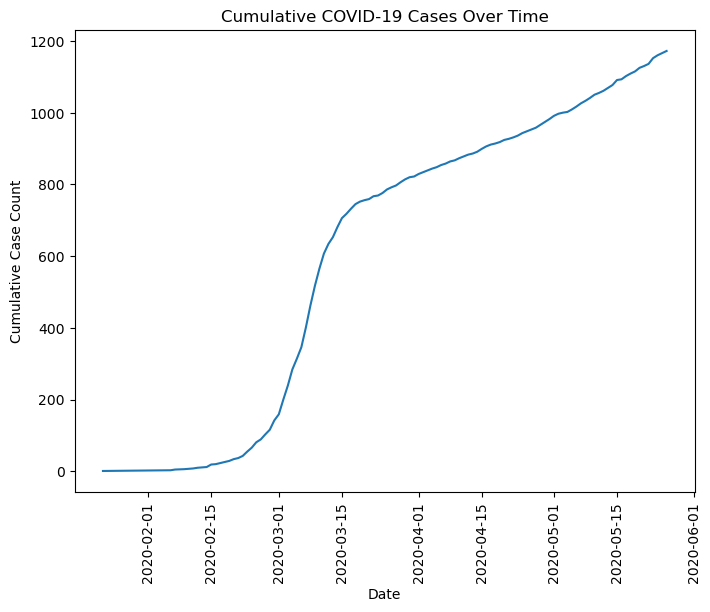

In [141]:
from matplotlib import pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window


parsed_notes = parsed_notes.withColumn(
    'covid_result',
    F.lower(F.col('laboratory')['covid19']['result']).cast(StringType())
)

positive_covid_cases = parsed_notes.filter(
    col("laboratory.covid19.result") == "Detected (qualifier value)"
)

# Add a column for the encounter date
positive_covid_cases = positive_covid_cases.withColumn(
    'encounter_date',
    F.to_date(F.col('encounter')['date'], 'yyyy-MM-dd')
)

most_recent_case = positive_covid_cases.agg(F.max('encounter_date')).collect()[0][0]
daily_case_counts = positive_covid_cases.groupBy('encounter_date').count()
daily_case_counts = daily_case_counts.orderBy('encounter_date')
daily_case_counts = daily_case_counts.withColumn(
    'cumulative_case_count',
    F.sum('count').over(Window.orderBy('encounter_date'))
)


daily_case_counts_pd = daily_case_counts.toPandas()
plt.figure(figsize=(8,6))
plt.plot(
    daily_case_counts_pd['encounter_date'],
    daily_case_counts_pd['cumulative_case_count'],
)
plt.title('Cumulative COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Case Count')
plt.xticks(rotation=90)
plt.show()


Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.

In [ ]:
# I was unable to do this one, I couldn't figure out how to connect the icu value and the note

Rank medications by frequency of prescription

In [142]:
from pyspark.sql.functions import explode

# Flatten medication data and calculate frequencies
medication_ranking = parsed_notes.select(explode(col("medications")).alias("medication")) \
    .groupBy("medication.description").count() \
    .orderBy(col("count").desc())

medication_ranking.show()

+--------------------+-----+
|         description|count|
+--------------------+-----+
|Acetaminophen 500...|  302|
|0.4 ML Enoxaparin...|  291|
|1 ML Epoetin Alfa...|  214|
|1 ML Enoxaparin s...|  174|
|NDA020503 200 ACT...|  165|
|insulin human  is...|   88|
|Simvastatin 10 MG...|   83|
|Hydrochlorothiazi...|   82|
|24 HR Metformin h...|   69|
|amLODIPine 5 MG /...|   52|
|Atenolol 50 MG / ...|   50|
|120 ACTUAT Flutic...|   49|
|Acetaminophen 325...|   46|
|Digoxin 0.125 MG ...|   36|
|Verapamil Hydroch...|   36|
|Warfarin Sodium 5...|   36|
|Clopidogrel 75 MG...|   35|
|Simvastatin 20 MG...|   31|
|Amlodipine 5 MG O...|   31|
|Nitroglycerin 0.4...|   31|
+--------------------+-----+
only showing top 20 rows



Analyze medication patterns across different demographic groups (e.g., top 3 per age group)


In [143]:
# Join age group data with medications
medication_by_age = df_with_age_groups.select(
    "age_group", explode(col("medications")).alias("medication")
).groupBy("age_group", "medication.description").count()

# Get top 3 medications per age group
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

window = Window.partitionBy("age_group").orderBy(col("count").desc())

top_medications_by_age = medication_by_age.withColumn(
    "rank", rank().over(window)
).filter(col("rank") <= 3)

top_medications_by_age.show()



+---------+--------------------+-----+----+
|age_group|         description|count|rank|
+---------+--------------------+-----+----+
|    [0-5]|Ibuprofen 100 MG ...|    3|   1|
|    [0-5]|1 ML Enoxaparin s...|    1|   2|
|    [0-5]|Acetaminophen 21....|    1|   2|
|    [0-5]|Amoxicillin 250 M...|    1|   2|
|    [0-5]|0.4 ML Enoxaparin...|    1|   2|
|    [0-5]|NDA020503 200 ACT...|    1|   2|
|    [0-5]|Acetaminophen 500...|    1|   2|
|  [11-17]|NDA020503 200 ACT...|   14|   1|
|  [11-17]|120 ACTUAT Flutic...|   11|   2|
|  [11-17]|Acetaminophen 500...|    9|   3|
|  [11-17]|0.4 ML Enoxaparin...|    9|   3|
|  [18-30]|Acetaminophen 500...|   35|   1|
|  [18-30]|0.4 ML Enoxaparin...|   34|   2|
|  [18-30]|1 ML Enoxaparin s...|   21|   3|
|  [31-50]|Acetaminophen 500...|   63|   1|
|  [31-50]|0.4 ML Enoxaparin...|   62|   2|
|  [31-50]|NDA020503 200 ACT...|   32|   3|
|  [51-70]|Acetaminophen 500...|  119|   1|
|  [51-70]|0.4 ML Enoxaparin...|  118|   2|
|  [51-70]|1 ML Epoetin Alfa...|

Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 


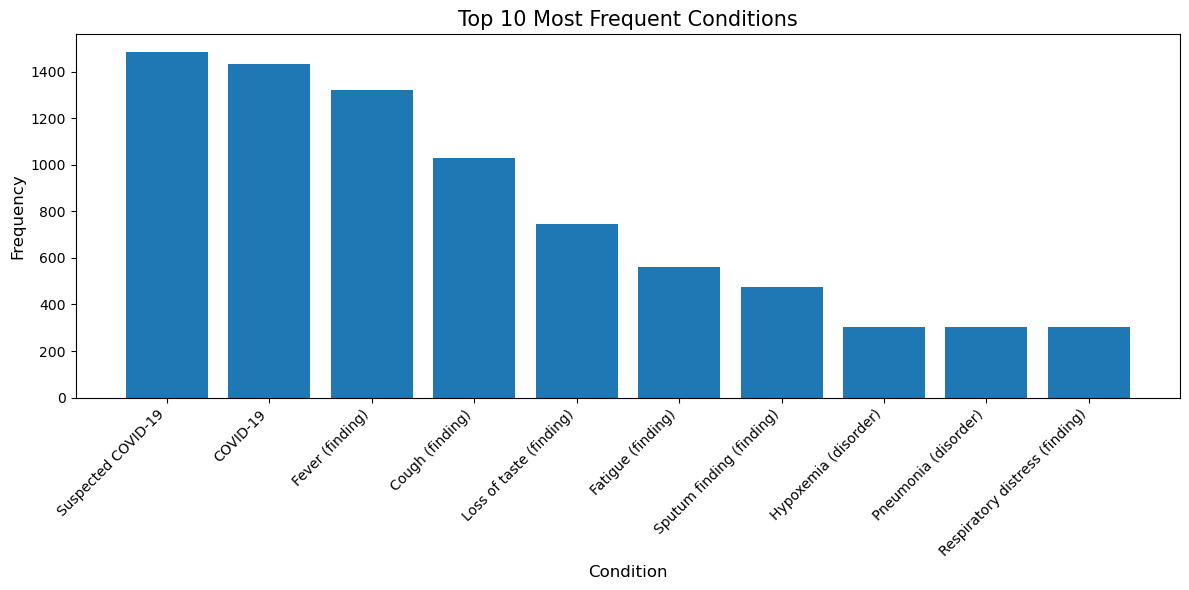

In [144]:
# Filter and count co-morbidities
co_morbidity_analysis = parsed_notes.select(explode(col("conditions")).alias("condition")) \
    .groupBy("condition.description").count() \
    .orderBy(col("count").desc())

descriptions = co_morbidity_analysis.select("description").limit(10).toPandas()["description"]
counts = co_morbidity_analysis.select("count").limit(10).toPandas()["count"]

plt.figure(figsize=(12, 6))
plt.bar(descriptions, counts)
plt.title('Top 10 Most Frequent Conditions', fontsize=15)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Independent group analysis

Question: Are COVID-19 infection rates significantly different between male and female patients?

Justification: Understanding the distribution of positive cases by gender can provide insights into whether gender influences susceptibility to COVID-19, which may inform public health decisions.

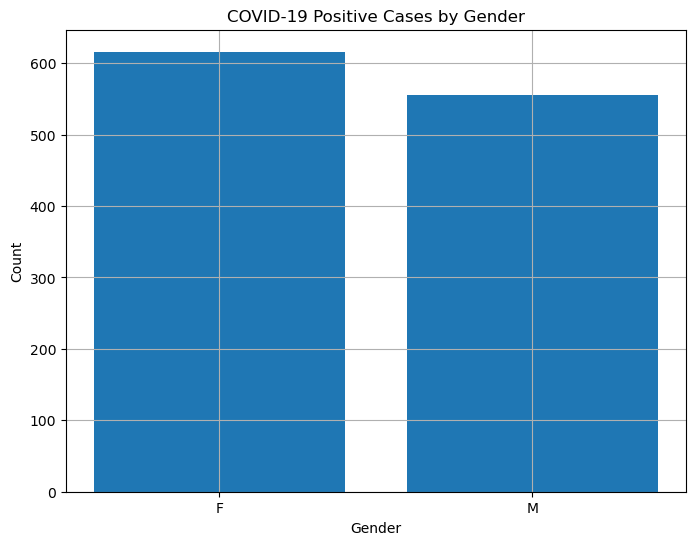

In [145]:
covid_gender_distribution = parsed_notes.filter(
    col("laboratory.covid19.result") == "Detected (qualifier value)"
).groupBy("demographics.gender").count().orderBy(col("count").desc())

covid_gender_pd = covid_gender_distribution.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(covid_gender_pd['gender'], covid_gender_pd['count'])
plt.title('COVID-19 Positive Cases by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)
plt.show()


Question: Do COVID-19 positive patients exhibit higher average body temperatures compared to non-positive patients?

Justification: Fever is a common symptom of COVID-19. Analyzing average body temperatures can help quantify the presence of fever among positive cases and support diagnosis.


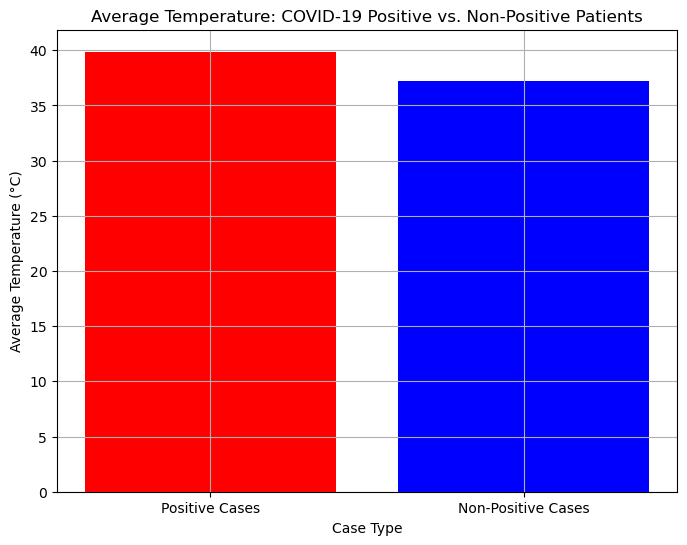

In [146]:
from pyspark.sql.functions import col, avg

# Extract body temperature values for positive and non-positive cases
positive_cases_temp = parsed_notes.filter(
    col("laboratory.covid19.result") == "Detected (qualifier value)"
).select(
    col("vitals.current.temperature.value").alias("temperature")
)

non_positive_cases_temp = parsed_notes.filter(
    col("laboratory.covid19.result") != "Detected (qualifier value)"
).select(
    col("vitals.current.temperature.value").alias("temperature")
)

# Calculate average temperature for positive and non-positive cases
positive_avg_temp = positive_cases_temp.agg(
    avg("temperature").alias("average_temp_positive")
).collect()[0]["average_temp_positive"]

non_positive_avg_temp = non_positive_cases_temp.agg(
    avg("temperature").alias("average_temp_non_positive")
).collect()[0]["average_temp_non_positive"]


# Visualization
categories = ["Positive Cases", "Non-Positive Cases"]
values = [positive_avg_temp, non_positive_avg_temp]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=["red", "blue"])
plt.title("Average Temperature: COVID-19 Positive vs. Non-Positive Patients")
plt.xlabel("Case Type")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)
plt.show()


Question: Do COVID-19 positive case outcomes (e.g., ICU admissions, hospital admissions) vary depending on the day of the week the encounter occurred?

Justification: Identifying patterns in case outcomes based on the day of the week can help healthcare providers allocate resources more effectively and improve patient care.

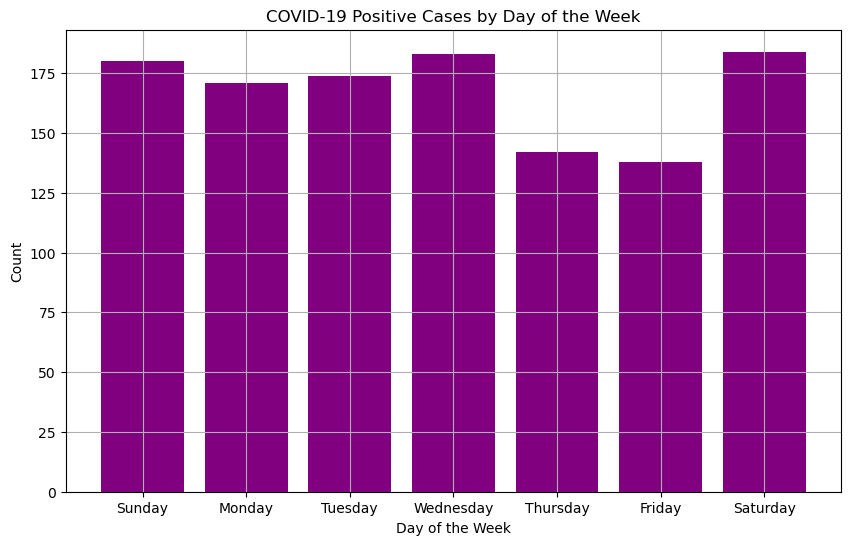

In [147]:
from pyspark.sql.functions import dayofweek, col, to_date

df_with_day_of_week = parsed_notes.withColumn(
    "day_of_week", dayofweek(to_date(col("encounter.date")))
)

day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
               5: "Thursday", 6: "Friday", 7: "Saturday"}

positive_cases_by_day = df_with_day_of_week.filter(
    col("laboratory.covid19.result") == "Detected (qualifier value)"
).groupBy("day_of_week").count().orderBy("day_of_week")

positive_cases_pd = positive_cases_by_day.toPandas()
positive_cases_pd['day_of_week'] = positive_cases_pd['day_of_week'].map(day_mapping)

plt.figure(figsize=(10, 6))
plt.bar(positive_cases_pd['day_of_week'], positive_cases_pd['count'], color='purple')
plt.title('COVID-19 Positive Cases by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.grid(True)
plt.show()
